# Install and Import Libraries

In [1]:
!pip install transformers
!pip install gputil

In [2]:
import pickle
import json
import time
import datetime
import numpy as np
import pandas as pd
import torch
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, AutoModel, AdamW
import GPUtil

if torch.cuda.is_available():    
  # Tell PyTorch to use the GPU.    
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Load Dataset

In [3]:
taxonomy_df = pickle.load(open('taxonomy.pickle', 'rb'))
taxonomy_df.head()

,Category,Description
0,0,Botany is the science of plant life and a bran...
1,0,"Genetic engineering, also called genetic modif..."
2,0,Herbicide tolerance consists of chemical herbi...
3,0,Insect resistance is a trait that increases a ...
4,0,A microorganism or microbe is a microscopic or...


In [4]:
taxonomy_df.shape

(6853, 2)

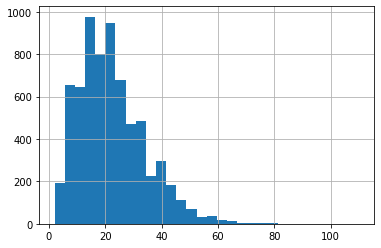

In [5]:
#plot the lengths of tag descriptions
seq_len = [len(i.split()) for i in taxonomy_df['Description']]
pd.Series(seq_len).hist(bins=30)

In [6]:
maxlen = 128
classes = []
rows = 0
sentences = []
input_ids = []
attention_masks = []
labels = []
for index, row in taxonomy_df.iterrows():
	#encode categories into numerical labels
	rows += 1
	if row['Category'] not in classes:
		classes.append(row['Category'])
	labels.append(row['Category'])
	#encode sentences to prepare for BERT
	sentences.append(row['Description'])
	encoded_dict = tokenizer.encode_plus(
      row['Description'],
      add_special_tokens=True,
      max_length=maxlen,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt'
  )
	input_ids.append(encoded_dict['input_ids'])
	attention_masks.append(encoded_dict['attention_mask'])

#convert into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
print("There are {} unique categories and {} rows.".format(len(classes), rows))
print("SAMPLE")
print("Original: ", sentences[0])
print("Token IDs:", input_ids[0])
print("Attention:", attention_masks[0])
print("Label:", np.unique(labels))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


There are 170 unique categories and 6853 rows.
SAMPLE
Original:  Botany is the science of plant life and a branch of biology.
Token IDs: tensor([  101, 17018,  2003,  1996,  2671,  1997,  3269,  2166,  1998,  1037,
         3589,  1997,  7366,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
     

# Create Dataloaders

In [7]:
batch_size = 32
train_data = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_sampler = torch.utils.data.SequentialSampler(train_data)
val_dataloader = torch.utils.data.DataLoader(train_data, sampler=val_sampler, batch_size=batch_size)

# Define Model Architecture

In [8]:
class BERT_Arch(torch.nn.Module):

  def __init__(self, bert, n_classes):
    super(BERT_Arch, self).__init__()
    self.classes = n_classes
    self.bert = bert
    #defining the layers of the model
    self.dropout = torch.nn.Dropout(0.1)
    self.relu = torch.nn.ReLU()
    self.fc1 = torch.nn.Linear(768,512)
    self.fc2 = torch.nn.Linear(512,self.classes)
    self.softmax = torch.nn.Softmax(dim=1)

  def forward(self, sent_id, mask):
    _, cls_hs = self.bert(sent_id, attention_mask=mask)
    #executing the layers of the model, which take the classification token as input
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.softmax(x)

    return x

In [9]:
bert = AutoModel.from_pretrained('bert-base-uncased')
#freeze all parameters
for param in bert.parameters():
  param.requires_grad = False
#instantiate BERT Arch model
model = BERT_Arch(bert, len(classes))
model = model.to(device)

# Find Class Weights

In [10]:
'''class_wts = compute_class_weight('balanced', classes=np.unique(labels), y=np.array(labels))
print(class_wts)
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)'''

#loss function
cross_entropy = torch.nn.NLLLoss()#weight=weights)

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-3)

# Fine-Tune BERT

In [11]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  t0 = time.time()
  print("===== TRAINING =====")

  for step, batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print("\tBatch {:>5} of {:>5}.".format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    #print("Loss for batch {}: {}".format(step, loss))
    total_loss = total_loss + loss.item()
    if step % 50 == 0 and not step == 0:
      print("\tTotal Loss: {}".format(total_loss))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  total_preds = np.concatenate(total_preds, axis=0)
  training_time = format_time(time.time() - t0)

  print("")
  print("\tAverage training loss: {0:.2f}".format(avg_loss))
  print("\tTraining epcoh took: {:}".format(training_time))

  return avg_loss, total_preds

In [12]:
def evaluate():
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  t0 = time.time()
  print("=====EVALUATING=====")

  for step, batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print("\tBatch {:>5} of {:>5}.".format(step, len(val_dataloader)))
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader)
  evaluation_time = format_time(time.time() - t0)

  print("")
  print("\tAverage Validation Loss: {0:.2f}".format(avg_loss))
  print("\tEvaluation epoch took: {:}".format(evaluation_time))

  total_preds = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [13]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
#check the GPU memory use at this point
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  7% |  9% |


In [15]:
epochs = 10
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
total_t0 = time.time()
best_model = 0

for epoch in range(epochs):
  print("\n Epoch {:} / {:}".format(epoch + 1, epochs))
  train_loss, _ = train()
  print("")
  valid_loss, _ = evaluate()
  torch.save(model.state_dict(), 'saved_weights' + str(epoch + 1) + '.pt')
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    best_model = epoch + 1
  
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  print(f"\nTraining Loss: {train_loss:.3f}")
  print(f"Validation Loss: {valid_loss:.3f}")

total_elapsed = format_time(time.time() - total_t0)
print("Total time to train: {:}".format(total_elapsed))
print("Best model was from epoch {}.".format(best_model))


 Epoch 1 / 10
===== TRAINING =====
	Batch    50 of   215.
	Total Loss: -3.1060149665432846
	Batch   100 of   215.
	Total Loss: -7.024083153633294
	Batch   150 of   215.
	Total Loss: -10.453945746512465
	Batch   200 of   215.
	Total Loss: -14.157117951062949

	Average training loss: -0.07
	Training epcoh took: 0:00:28

=====EVALUATING=====
	Batch    50 of   215.
	Batch   100 of   215.
	Batch   150 of   215.
	Batch   200 of   215.

	Average Validation Loss: -0.07
	Evaluation epoch took: 0:00:26

Training Loss: -0.071
Validation Loss: -0.074

 Epoch 2 / 10
===== TRAINING =====
	Batch    50 of   215.
	Total Loss: -3.8125005737861724
	Batch   100 of   215.
	Total Loss: -7.375000573791721
	Batch   150 of   215.
	Total Loss: -11.000000573820673
	Batch   200 of   215.
	Total Loss: -14.687500700486707

	Average training loss: -0.07
	Training epcoh took: 0:00:28

=====EVALUATING=====
	Batch    50 of   215.
	Batch   100 of   215.
	Batch   150 of   215.
	Batch   200 of   215.

	Average Validation

# Load Saved Model

In [16]:
#load weights of best model
test_path = 'saved_weights' + str(best_model) + '.pt'
model.load_state_dict(torch.load(test_path))

#or if starting from here with a trained model
#model.load_state_dict(torch.load('BERT_w_Classifier_e10.py'))

<All keys matched successfully>

# Get Predictions for Test Data

In [17]:
#load test data
with open('Verification_Articles.json', 'r', encoding='utf-8') as test_file:
  test_dict = json.load(test_file)

test_input_ids = []
test_masks = []
test_labels = []
for art in test_dict['articles']:
  test_labels.append(art['category'])
  #summarize text -----THIS HAS TO BE DONE!!!!!-----
  #tokenize text
  encoded_dict = tokenizer.encode_plus(
    art['body'],
    add_special_tokens=True,
    max_length=maxlen,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
  )
  test_input_ids.append(encoded_dict['input_ids'])
  test_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_masks = torch.cat(test_masks, dim=0)
test_labels = torch.tensor(test_labels)

#make prediciton
with torch.no_grad():
  preds = model(test_input_ids.to(device), test_masks.to(device))
  preds = preds.detach().cpu().numpy()
  #print(preds)
  preds = np.argmax(preds, axis=1)

print(preds)

[36 36]


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Compare Predictions with Human Labels

In [18]:
from My_Indices import reverse_category_index

#decode predictions into category names
decoded_preds = []
for p in preds:
  decoded_preds.append(reverse_category_index[p+1])
print(decoded_preds)

['Technology', 'Technology']


# Tabulate Model Performance

In [19]:
#model's performance
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

          36       0.00      0.00      0.00       0.0
          69       0.00      0.00      0.00       1.0
         121       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
#confusion matrix
pd.crosstab(test_labels, preds)

col_0,36
row_0,
69,1
121,1
